# **4.2. Experiments on training with MMD only on synthetic target data on a multi-class setting**
We will now move towards a multi-class setting, where we choose randomly from 5 different classes of objects. This multi-class setting aims to further complete the study by analyzing what happens to the network's performance when tested under a multi-class setting using a custom dataset on a custom 3D rendering engine such as Unity. By completing this part of the study, we seek to understand whether using a multi-class setting aliviates the problems encountered in the single-class setting, due to its simplicity and therefore tendency to overfit, or have vanishing gradients. The five different objects are as shown below. We will conduct this study as the previous one, but simplifying the hyperparameter search, since the previous case proved that only employing learning rate decay and changing the number of pretraining epochs are the two hyperparameter settings that most affect the performance of the network.

#### Library imports
Let us import all relevant libraries to analyse our results from each of the experiments.

In [1]:
import pandas as pd
import cv2
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook as tqdm

### **Helper functions**
Let us define all the functions that will help in this study.

In [ ]:
from utils.helpers.distribution import *
from utils.helpers.feature_maps import *
from utils.helpers.gcn import *
from utils.helpers.mmd import *
from utils.helpers.read_write import *
from utils.helpers.shared import *

## **4.2.1. Learning to rotate 5 objects 90 degrees**
As per the previous section, we will define a target distribution centered around 90 degrees of standard deviation X, and we will initialize our distribution around 180 degrees with a standard deviation Y. As per the previous experiments, we wish our model to converge towards the target mean while keeping the standard deviation Y. This was not achievable under the explored settings in the previous sections. We hope that, by having more classes, this will help as a regularizer to the vanishing gradient problem observed before when increasing the number of pretraining epochs. Let us start by analyzing the pretraining performance of the GCN autoencoder.

In [11]:
ROOT_PATH = "../results/multi/1_attr"
RESULTS_PATH = "figures/multi/1_attr/4_2_1"

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


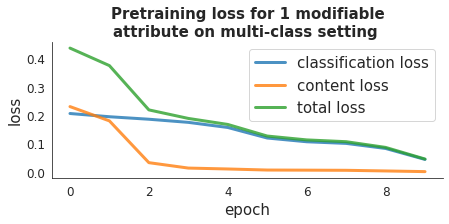

In [12]:
plot_pretraining_progress(
    experiment_n=3,
    title="Pretraining loss for 1 modifiable\nattribute on multi-class setting ",
    filename="multi_1attr_GCN_progress",
    size=(7, 2.5),
)

We can clearly see that, in contrast to the previous experiments where it was a single class setting, in this case the classification loss (class loss depicted in blue in the figure) is strictly higher than the content loss. This is clearly due to the fact that in this case we have a random sampler that assigns different random classes to the object node in the graph. The GCN here needs to learn how to sample according to the randomness initiated by the probablistic grammar sampling.

According to this, we decide to train our model for 10 MMD epochs after 1, 5, and 10 pretraining epochs, and similarly with learning rate decay every 2 epochs. In the following distribution plot we only plot results for 1 and 10 pretraining epochs, since these expressed more information about the impact of pretraining and learning rate decay in a Meta-Sim multi-class setting. The figure can be seen below.

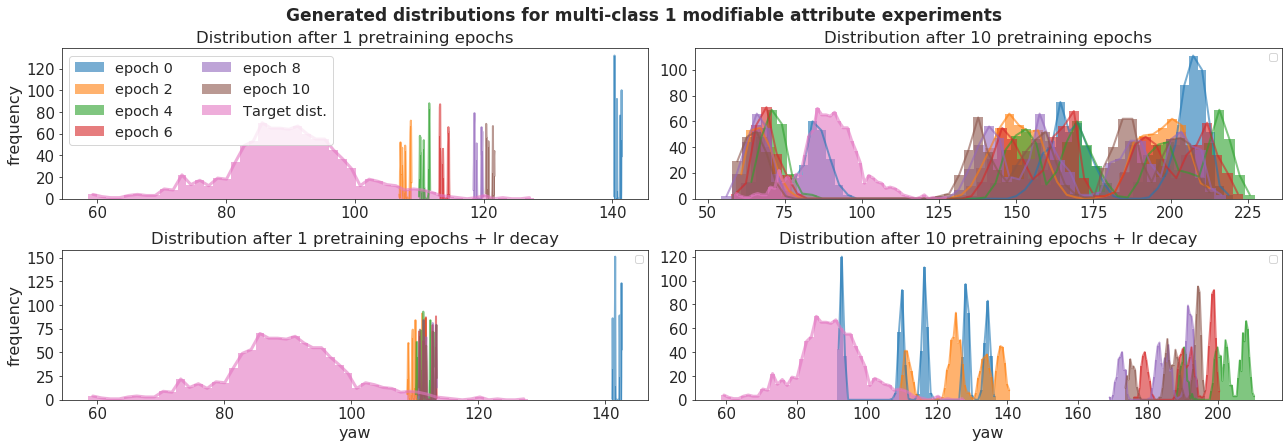

In [54]:
# Plot grid of distributions
titles = [
    "Distribution after 1 pretraining epochs",
    "Distribution after 10 pretraining epochs",
    "Distribution after 1 pretraining epochs + lr decay",
    "Distribution after 10 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [1, 3, 8, 5]
# Plot distribution grid
plt.suptitle(
    "Generated distributions for multi-class 1 modifiable attribute experiments",
    fontsize=17,
    fontweight="bold",
    y=1.03,
)
for i, exp in enumerate(exp_list):
    if exp == 8:
        interval = 5
    else:
        interval = 2
    fig = plot_distribution_grid(
        experiment=exp, interval=interval, size=(18, 6), title=titles[i], i=i
    )
    if exp == 1:
        plt.legend(prop={"size": 14.5}, ncol=2)
    else:
        plt.legend("")
    if i < 2:
        plt.xlabel(None)
    if i % 2 != 0:
        plt.ylabel(None)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"multi_1attr_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From these distribution plots there are a few interesting phenomena going on. Let's first look at the experiments on the left column, which correspond to 1 GCN pretraining epoch. We can see that in this case, as in the homologous single-class setting, the mean seems to be converging towards the target distribution's mean, but there seems to be no standard deviation due to the small pretraining time. We can also see that, contrary to the single-class setting, we have multiple peaks per epoch. Also, even thoough the target distribution is also a multi-class distribution, it doesn't seem to havethe same behaviour, why is this? This seems to be another of the many nuances that the Meta-Sim model has, this time in the distribution initialization. In the target distribution case, we define one Gaussian distribution per attribute, and then assign a sampled value to a randomly chosen class. In the generated distribution case (so in the probabilistic grammar), the contrary happens, a random class is chosen, and a Gaussian is defined for each attribute then, from which a value is sampled. Further investigating the impact of this initialization remains out of the scope of this study, and we don't rule out that this might slightly improve performance in the multi-class setting, since we would like to compare distributions of the same nature. Secondly, and still focusing on the left column, the learning rate decay keeps the distributions from moving further away from the target mean. This is because since the updates become smaller, the model has less chances to jump out of the local optima it found around ~106 degrees.

Furthermore, if we now shift our attention to the right column, we can see that actually pretraining the GCN for longer will generate more robust Gaussians around different means. This actually hints to a problem of using multi-modal Gaussians to initialize the GCN. If we observe the top right figure, we can see that one of the Gaussians corresponding to one of the classes is breaking away and almost matching the target distribution. This seems to be harmful because we would wish all distributions to shift equally towards the target distribution. This thus hints that in future work it would be more beneficial to start with a uni-modal Gaussian, rather than a multi-modal Gaussian. Additionally, and as in the 1 pretraining epoch case, the learning rate decay seems to narrow down the distributions and get each Gaussian closer together. We further conclude howevere that the 10 pretraining epochs are harmful to the learning of the target mean. This can be seen clearly in the following plot. Where we can see that using 10 pretraining epochs is actually harmful to the convergence of the network. On the contrary, we find that there is convergenge in the 1 pretraining epoch case, and the learning rate decay helps the network become stable around local optima.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


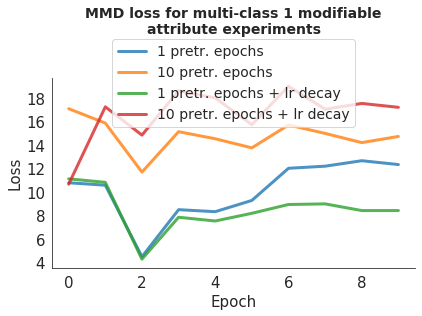

In [25]:
# Plot grid of distributions
labels = [
    "1 pretr. epochs",
    "10 pretr. epochs",
    "1 pretr. epochs + lr decay",
    "10 pretr. epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6.5, 3.5))
exp_list = [1, 3, 8, 5]

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=10)
    plt.legend(bbox_to_anchor=(0.5, 1.24), loc="upper center", fontsize=14)

plt.title(
    f"MMD loss for multi-class 1 modifiable\nattribute experiments",
    fontweight="bold",
    fontsize=14,
    y=1.2,
)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"multi_1attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

We can further confirm succesful learning of the network in this simple case by looking at randomly sampled generated images, and comparing them to a randomly sampled target image. From this we can see that after 2 epochs the network learns to rotate each object to its respective 90 degree position in the 3D scene. 

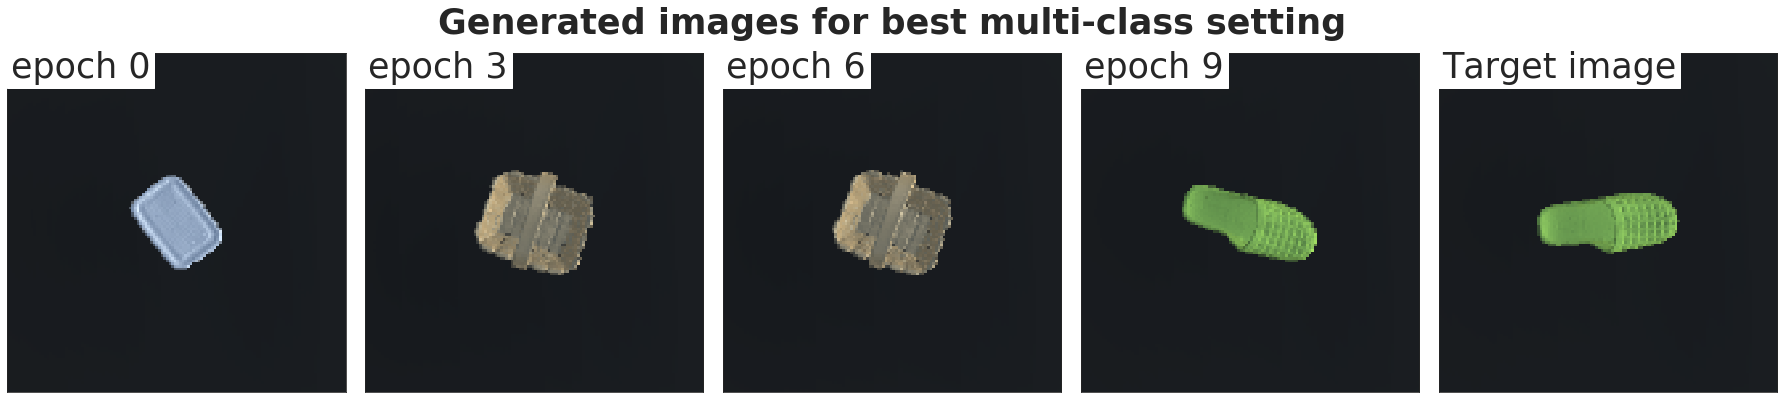

In [66]:
plot_each_image(
    experiment_n=8,
    interval=3,
    filename="multi_1attr_images",
    title="Generated images for best multi-class setting",
    total_epochs=10,
    fontsize=35,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


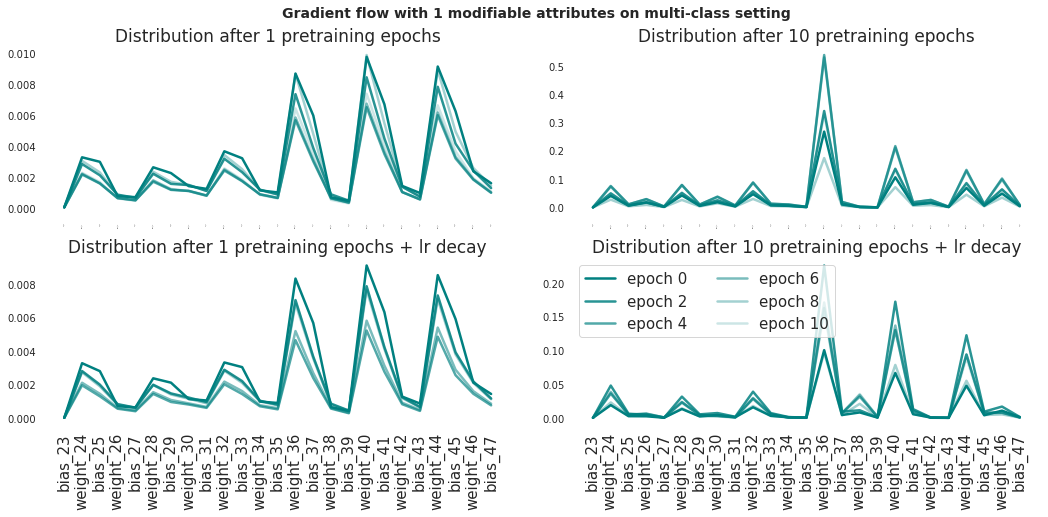

In [34]:
# Plot grid of distributions
titles = [
    "Distribution after 1 pretraining epochs",
    "Distribution after 10 pretraining epochs",
    "Distribution after 1 pretraining epochs + lr decay",
    "Distribution after 10 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [1, 3, 8, 5]
# Plot distribution grid
plt.suptitle(
    "Gradient flow with 1 modifiable attributes on multi-class setting",
    fontweight="bold",
    fontsize=14,
    y=1.02,
)
for i, exp in enumerate(exp_list):
    if exp == 1 or exp == 3:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 7),
            interval=2,
            title=titles[i],
            i=i,
            limit=11,
            alpha_mult=0.08,
        )
        plt.xticks(rotation=90, fontsize=0.05)
    else:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 7),
            interval=2,
            title=titles[i],
            i=i,
            limit=11,
            alpha_mult=0.08,
        )
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"multi_1attr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

## **4.2.2. Learning to rotate an object 90 degrees and change its position on a single-class setting**
We continue to complexify the scene by adding the location along x and along z in the 3D scene as mutable attributes. We adopt the same kind of "Gaussian clipping" adopted in the previous single-class homologous experiments. We choose to significantly increase the number of pretraining epochs to 50 and 75, since the number of mutable attributes, and classes has increased, we hope that this will help the network generate more robust distributions for all mutable attributes in the probabilistic grammar. We therefore perform 4 experiments with 50 and 75 pretraining epochs, and then add learning rate decay to each of these cases. In the following figure we plot the generated distributions for the yaw attribute in this multi-class setting.

In [67]:
ROOT_PATH = "../results/multi/3_attr"
RESULTS_PATH = "figures/multi/3_attr/4_2_2"

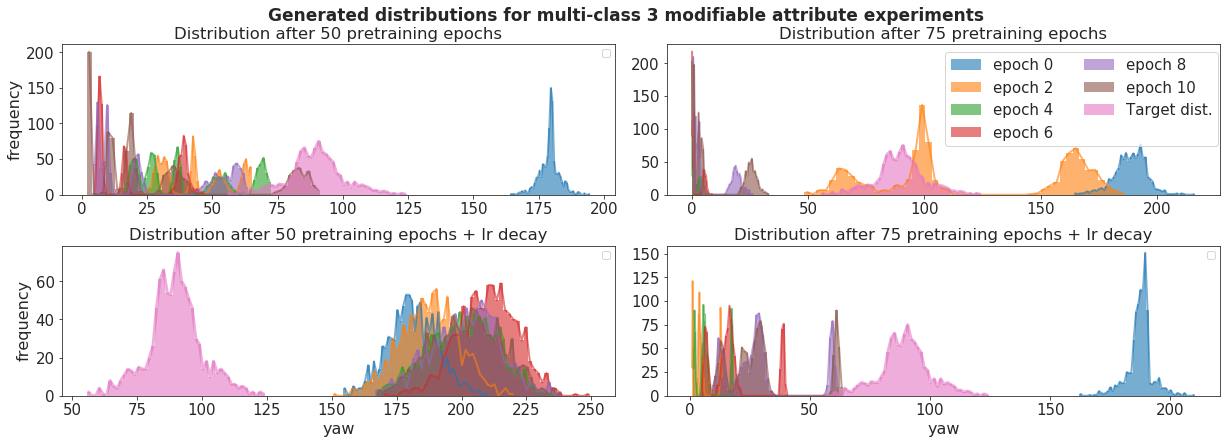

In [66]:
# Plot grid of distributions
titles = [
    "Distribution after 50 pretraining epochs",
    "Distribution after 75 pretraining epochs",
    "Distribution after 50 pretraining epochs + lr decay",
    "Distribution after 75 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [1, 2, 3, 4]
# Plot distribution grid
plt.suptitle(
    "Generated distributions for multi-class 3 modifiable attribute experiments",
    fontsize=17,
    fontweight="bold",
    y=1.02,
)
for i, exp in enumerate(exp_list):
    if exp == 8:
        interval = 5
    else:
        interval = 2
    fig = plot_distribution_grid(
        experiment=exp, interval=interval, size=(17.5, 6), title=titles[i], i=i
    )
    if exp == 2:
        plt.legend(
            prop={"size": 15}, ncol=2, loc="upper center", bbox_to_anchor=(0.75, 1)
        )
    else:
        plt.legend("")
    if i < 2:
        plt.xlabel(None)
    if i % 2 != 0:
        plt.ylabel(None)
plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"multi_3attr_yawdist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

From these distributions we can see that a similar phenomenon to the previous experiment occurs. In this case though the epoch 0 distribution remains as one single distribution and not multiple distributions. It is when the MMD loss starts updating the network (after the 1st epoch), that we observe multiple distributions being formed at each epoch. Similar to the previous set of experiments, it is when we add learning rate that the distributions for each epoch get closer together, as it's the case for the lower row of the plot. Finally, we can see that using 75 pretraining epochs and learning rate decay every 2 epochs is somewhat beneficial to the learned mean yaw distribution, since a distribution from the 8th and 10th epochs break away from the stagnated group around ~25 degrees, and move towards ~60 degrees rotation, attempting to match the target ~90 degrees. We conclude that there is no clear convergenge towards the target mean, but that this particular experiment is approaching convegence. Further experimenting in this direction would be interesting, but using a uni-modal distribution as the generated distribution, we leave this for future work.

Moreover, we plot the distribution of generated positions, where we can clearly see that there is no clear learning for the experiments without learning rate decay. Indeed, the distributions shift in the opposite direction to the target distribution, and stagnate around 0.85 for the location along z, and around 1.05 for the location along x. This is probably because the gradients of the network are vanishing and stuck at a local optima that puts the object out of frame, so our model is forced to bring it into frame with sampling from a Gaussian distribution that is centered around the above values (confirm this). On the contrary, when we add learning rate decay, the distributons seem to shift in the right direction, and more as the number of pretarining epochs increases. Indeed, the experiment with 75 pretraining epochs and learning rate decay every 2 epochs seems to be the one that performs the best. It doesn't fully converge towards the target distributions, but it at least shifts in its direction.

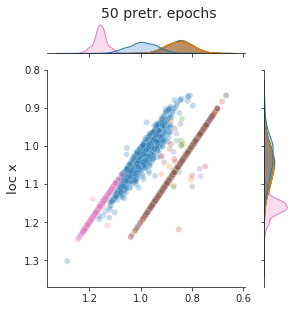

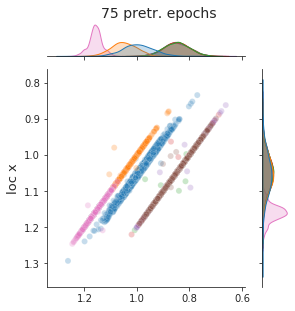

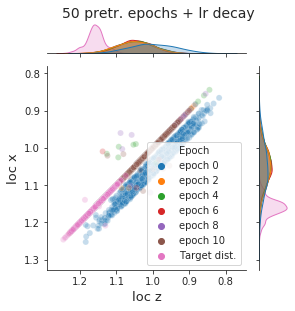

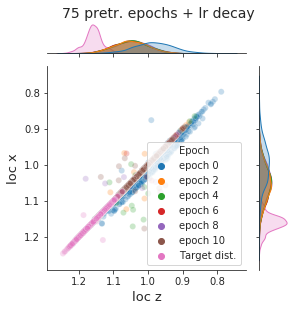

In [108]:
# Plot grid of distributions
titles = [
    "50 pretr. epochs",
    "75 pretr. epochs",
    "50 pretr. epochs + lr decay",
    "75 pretr. epochs + lr decay",
]
# Experiment list
exp_list = [1, 2, 3, 4]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    if i == 0 or i == 1:
        legend = False
        xlabel = None
    else:
        legend = True
        xlabel = "loc z"

    plot_loc_dist_grid(
        experiment_n=exp,
        title=titles[i],
        height=4.5,
        filename=f"multi_3attr_locdistr_{i}",
        interval=2,
        legend=legend,
        xlabel=xlabel,
        ylabel="loc x",
    )

We can further confirm this by looking at the MMD loss, where it is evident that the learning rate decay is keeping the loss at a much lower level than the experiments without learning rate decay. There is still no definite convergence but at least the loss stabilizes at a fairly low level for the cases with learning rate decay. 

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


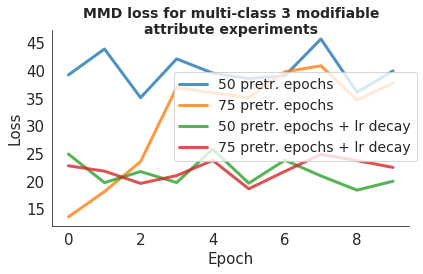

In [36]:
# Plot grid of distributions
labels = [
    "50 pretr. epochs",
    "75 pretr. epochs",
    "50 pretr. epochs + lr decay",
    "75 pretr. epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6.4, 3.6))
exp_list = [1, 2, 3, 4]

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=10)
    plt.legend(bbox_to_anchor=(1.04, 0.82), loc="upper right", fontsize=14)

plt.title(
    f"MMD loss for multi-class 3 modifiable\nattribute experiments",
    fontweight="bold",
    fontsize=14,
    y=0.95,
)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"multi_3attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

Finally, we can visualize below some of the generated images every 5 epochs of MMD training. From this we can see that by epoch 10 the network learns to generate samples that are located around the bottom left corner. The network however doesn't learn to rotate correctly the basket in the 3rd image from left to right, since it should be horizontal, and in this case it's oriented vertically.

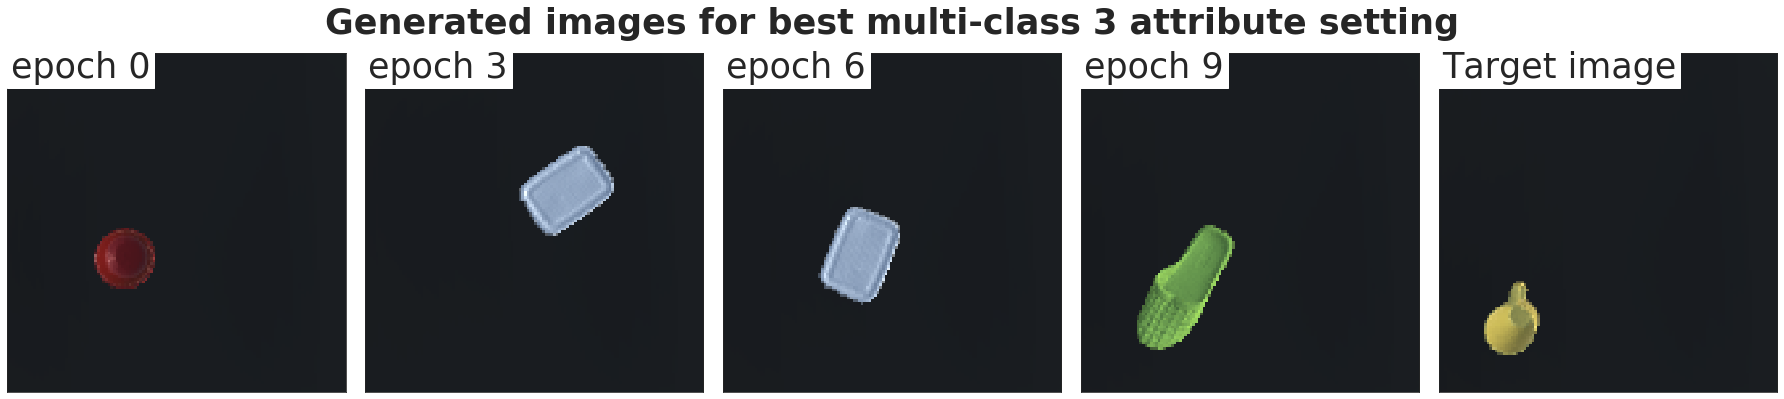

In [113]:
plot_each_image(
    experiment_n=3,
    interval=3,
    filename="multi_3attr_images",
    title="Generated images for best multi-class 3 attribute setting",
    total_epochs=10,
    fontsize=35,
)

## **4.2.3. Learning to fully rotate an object and change its position on a single-class setting**
We continue to complexify the scene by adding the other two components for the rotation of the object, pitch and roll, on the multi-class setting. We continue to analyze the behavior of the network and its components when more attributes are added. We specifically want to observe how the full distributions are generated for each attribute, and how the fact that more attributes mean more flexibility for the model to manipulate the generated images impacts its own performance. Indeed, and we will observe this clearly in the next section, the fact that more attributes are added gives the model more chances to fail and get stuck in local optima, because more attributes need to be tuned to a specific distributions to allow correct convergence of the model.

In [183]:
ROOT_PATH = "../results/multi/5_attr/"
RESULTS_PATH = "figures/multi/5_attr/4_2_3"

As per its single-class homologous, we plot a 3D plot where all pitch, yaw, and roll sample values are plotted, and we observe whether there is a pattern in the generated distributions of shifting towards the target distribution. We train 4 different models, pretrained during 75 and 100 epochs, and we add learning rate decay in the later two experiments. In this case, the same phenomenon we saw of muli-modal distribution splitting is happening with the rotations. We can see that only at epoch 0 the distributions seem to be grouped together in a similar shape as the target distribution. It is just after that epoch, at epoch 2, that we can notice 5 separate blobs forming, we assume this corresponds to the distributions of the 5 classes. We can also observe a similar phenomenon of mode collapse when there is no learning rate decay, present in the first two plots from left to right, and more predominant in the 100 pretraining epochs case. This is indeed allieviated using learning rate decay, as the two other plots suggest. However, even though the latter two experiments can still reproduce distributios after 4 epochs of training, they still don't learn the target distribution for the full rotation attributes. If we focus on the 100 pretraining epochs + learning rate decay experiment, we can see that the generated samples are close to the target distribution in the yaw (y) and roll (z) dimensions, but not on the pitch (x) dimensions.

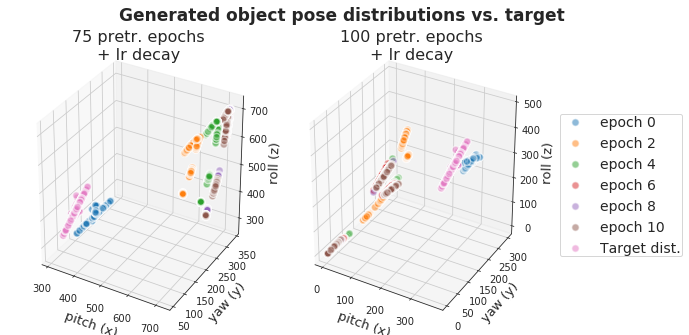

In [261]:
# Experiment list
exp_list = [4, 5]

# Plot grid of distributions
title = "Generated object pose distributions vs. target"
sub_titles = ["75 pretr. epochs\n+ lr decay", "100 pretr. epochs\n+ lr decay"]

# Plot full 3D plot
create_3D_rotation(
    exp_list=exp_list,
    interval=1,
    title=title,
    sub_titles=sub_titles,
    filename="multi_5attr_fullrotdist",
)

If we now focus our attention to the generated location distributions, we can see that, similarly to the rotation distributions, the first three experiments are not consistent in shifting the generated distributions towards the target mean. It is only using 100 pretraining epoch and learning rate decay that allows the network to generate distriutions of locations that are closer to the target distributions. 

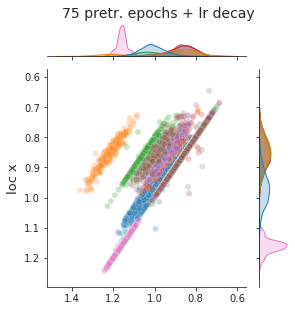

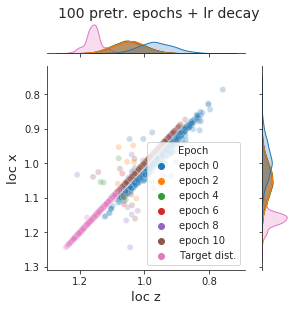

In [110]:
# Plot grid of distributions
titles = ["75 pretr. epochs + lr decay", "100 pretr. epochs + lr decay"]
# Experiment list
exp_list = [4, 5]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    if i == 0:
        legend = False
        xlabel = None
    else:
        legend = True
        xlabel = "loc z"
    plot_loc_dist_grid(
        experiment_n=exp,
        title=titles[i],
        height=4.5,
        filename=f"multi_5attr_locdistr_{i}",
        interval=1,
        legend=legend,
        xlabel=xlabel,
        ylabel="loc x",
    )

We can further confirm that the last experiment is able to generate samples that are close to the bottom left corner, and that match in pitch and roll, but not on yaw with the target images. From the figure below, the epoch 10 image contains an image of a basket. We can see that the position is closer to the bottom left corner, and pose of the object is similar to the target basket, except for the yaw, where the generated is oriented vertically, and the target is oriented almost horizontally. 

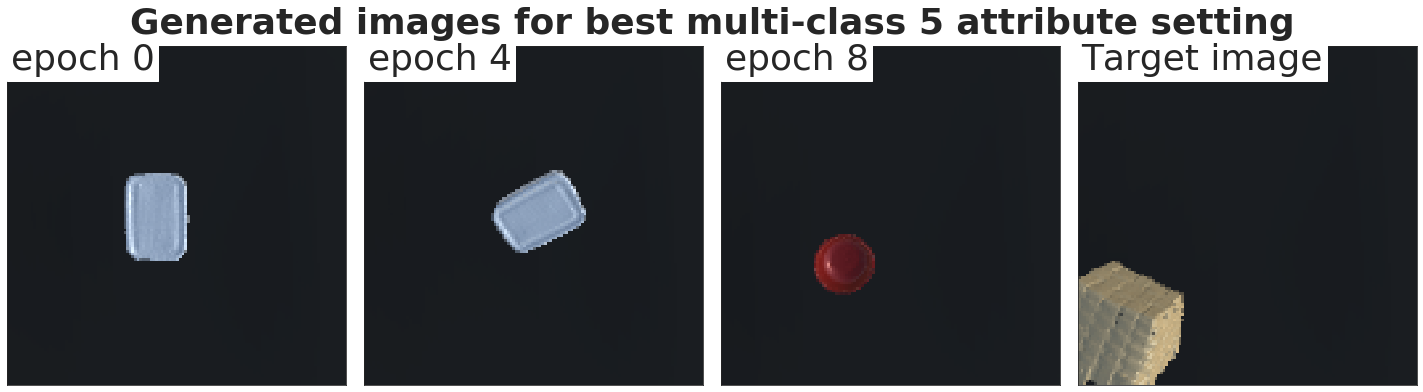

In [180]:
plot_each_image(
    experiment_n=5,
    interval=2,
    filename="multi_3attr_images",
    title="Generated images for best multi-class 5 attribute setting",
    total_epochs=10,
    fontsize=36,
)

From this set of experiments we can shed more light into the difficulty of adding more variation in the scene for the Meta-Sim model to manipulate. Indeed, the more variation we add, the more unstable the learning becomes. The generated samples have too many degrees of freedom and they can easily become too different to the target samples and let the learning stagnate at some local optima. This is further exhacerbated in the following (and final) set of experiments, where we add the camera rotation and light intensity attributes.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


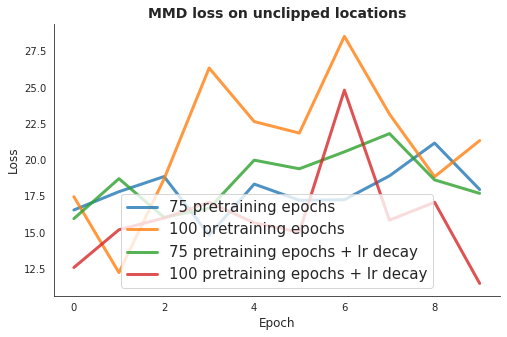

In [193]:
# Plot grid of distributions
labels = [
    "75 pretraining epochs",
    "100 pretraining epochs",
    "75 pretraining epochs + lr decay",
    "100 pretraining epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 5))
exp_list = [2, 3, 4, 5]

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=10)

plt.title(f"MMD loss on unclipped locations", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"multi_5attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

## **4.2.4. Adding more nodes: learning to rotate the camera and change light intensity**
We finalize our set of experiments on the Meta-Sim architecture with a custom 3D scene and a custom 3D rendering engine by further complexifying the scene to have 8 modifiable attributes and 6 nodes, as per the single-class case. This is the final test that the Meta-Sim architecture will undergo, and we wish to understand how giving the model freedom over the rotation of the camera along two axis (pitch and roll), and the intesity of the light, will affect both the learning and the generated samples. To test this, we use the same learning parameters as the previous experiment and we investigate the generated distributions. In this case, we will limit ourselves at looking at the generated distributions for the 3 new modifiable attributes, in order to understand how the architecture behaves when allowing it to control two more nodes in the 3D scene. 

Let's define the root path from where the results are found.

In [19]:
ROOT_PATH = "../results/multi/8_attr"
RESULTS_PATH = "figures/multi/8_attr/4_2_4"

We start by looking at the generated distributions for both rotations of the camera in the figure below. In this case, we perform the same type of "Gaussian clipping" as for the location attributes, since the camera rotation can also drive the object out of frame and stagnate at some local optima where the camera is just looking at the sky. We therefore define two Gaussians for each attribute to sample from when the camera takes the object out of frame. In this case, this is particularly relevant because if we look at the figure, the network doesn't seem to be learning to shift the distributions of these attributes. On the contrary, the predefined distribution is alligned with the target distribution, and when the MMD training starts (after epoch 1), the distributions are simply moved away from the target distribution. We can conclude that the architecture is not learning to modify the camera attributes to fit the target attributes.

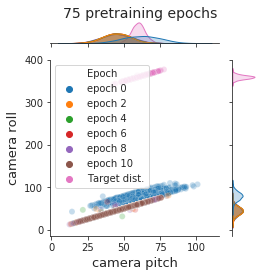

In [20]:
# Plot grid of distributions
titles = ["75 pretraining epochs"]
# Experiment list
exp_list = [1]
# Plot distribution grid
for i, exp in enumerate(exp_list):
    plot_camera_dist_grid(
        experiment_n=exp,
        interval=1,
        height=4,
        filename=f"multi_8attr_camdistr_{i}",
        title=titles[i],
    )

Furthermore, we plot the generated distributions for the light instensity parameter below. From the figure we can quickly conclude that there is mode collapse happening for this attribute. Indeed, the architecture is not even learning the initial distribution of the sampled attributes, which results in all values eventually collapsing to 0. This is a sign that the architecture was not pre-trained for long enough, and further exploration into this issue is left as future work, since there seems to be a combination of issues that cause mode collapse, and this is present from the simplest case, up until the most complicated case in this study.

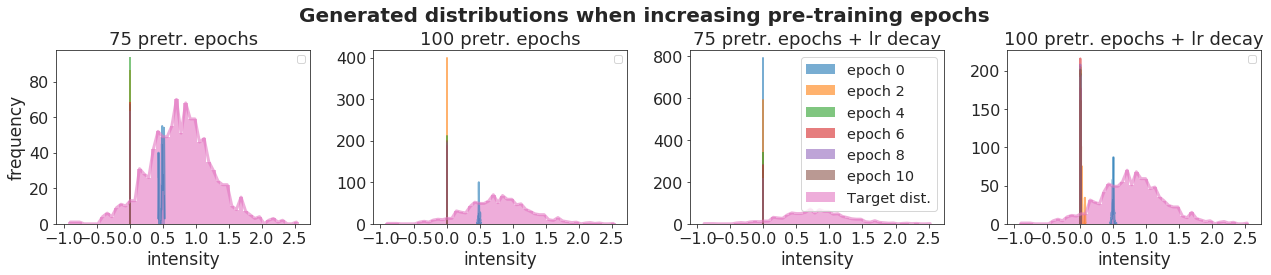

In [22]:
# Plot grid of distributions
titles = [
    "75 pretr. epochs",
    "100 pretr. epochs",
    "75 pretr. epochs + lr decay",
    "100 pretr. epochs + lr decay",
]
# Experiment list
exp_list = [1, 2, 3, 4]
# Plot distribution grid
plt.suptitle(
    "Generated distributions when increasing pre-training epochs",
    fontsize=20,
    fontweight="bold",
    y=1.05,
)
for i, exp in enumerate(exp_list):
    fig = plot_distribution_grid(
        experiment=exp,
        interval=1,
        rows=1,
        columns=4,
        size=(18, 3.6),
        title=titles[i],
        i=i,
        parameter="intensity",
    )
    plt.legend(loc="upper right", fontsize=14.5)

    if exp != 3:
        plt.legend("")
    if exp > 1:
        plt.ylabel(None)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"multi_8attr_intendist.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

We can prove mode collapse by looking at the gradients for each experiment passing through the GCN decoder. All gradients except for the 75 pretraining epochs with learning rate decay experiment are eventually collapsing to 0.

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


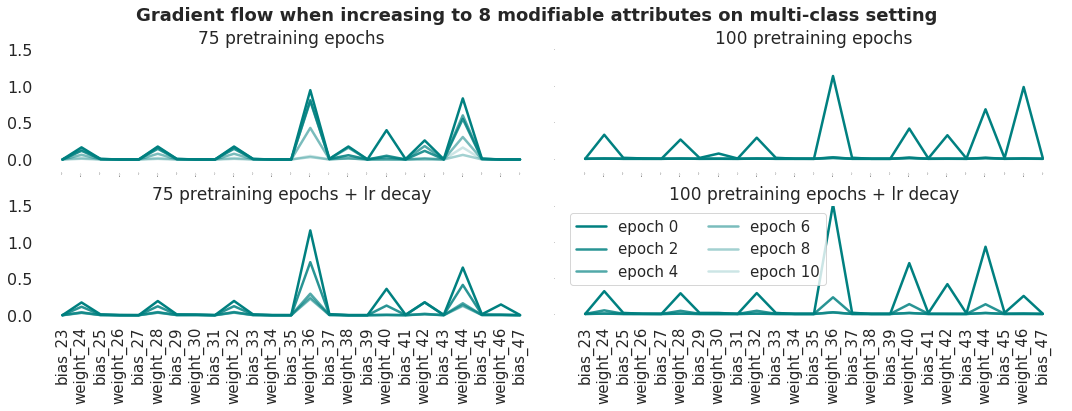

In [129]:
# Plot grid of distributions
titles = [
    "75 pretraining epochs",
    "100 pretraining epochs",
    "75 pretraining epochs + lr decay",
    "100 pretraining epochs + lr decay",
]
# Experiment list
exp_list = [1, 2, 3, 4]
# Plot distribution grid
plt.suptitle(
    "Gradient flow when increasing to 8 modifiable attributes on multi-class setting",
    fontweight="bold",
    fontsize=18,
    y=1.03,
)
for i, exp in enumerate(exp_list):
    if exp == 1 or exp == 2:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 5.5),
            interval=2,
            title=titles[i],
            i=i,
            limit=11,
            alpha_mult=0.08,
        )
        plt.xticks(rotation=90, fontsize=0.05)
    else:
        fig = plot_gradients_grid(
            experiment_n=exp,
            rows=2,
            columns=2,
            size=(15, 5.5),
            interval=2,
            title=titles[i],
            i=i,
            limit=11,
            alpha_mult=0.08,
        )

    plt.yticks(fontsize=16)
    plt.ylim(top=1.5)
    if i % 2 != 0:
        plt.yticks(fontsize=0.001)

plt.tight_layout()
plt.show()
fig.figure.savefig(
    os.path.join(RESULTS_PATH, f"multi_8attr_gradient_flow.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)

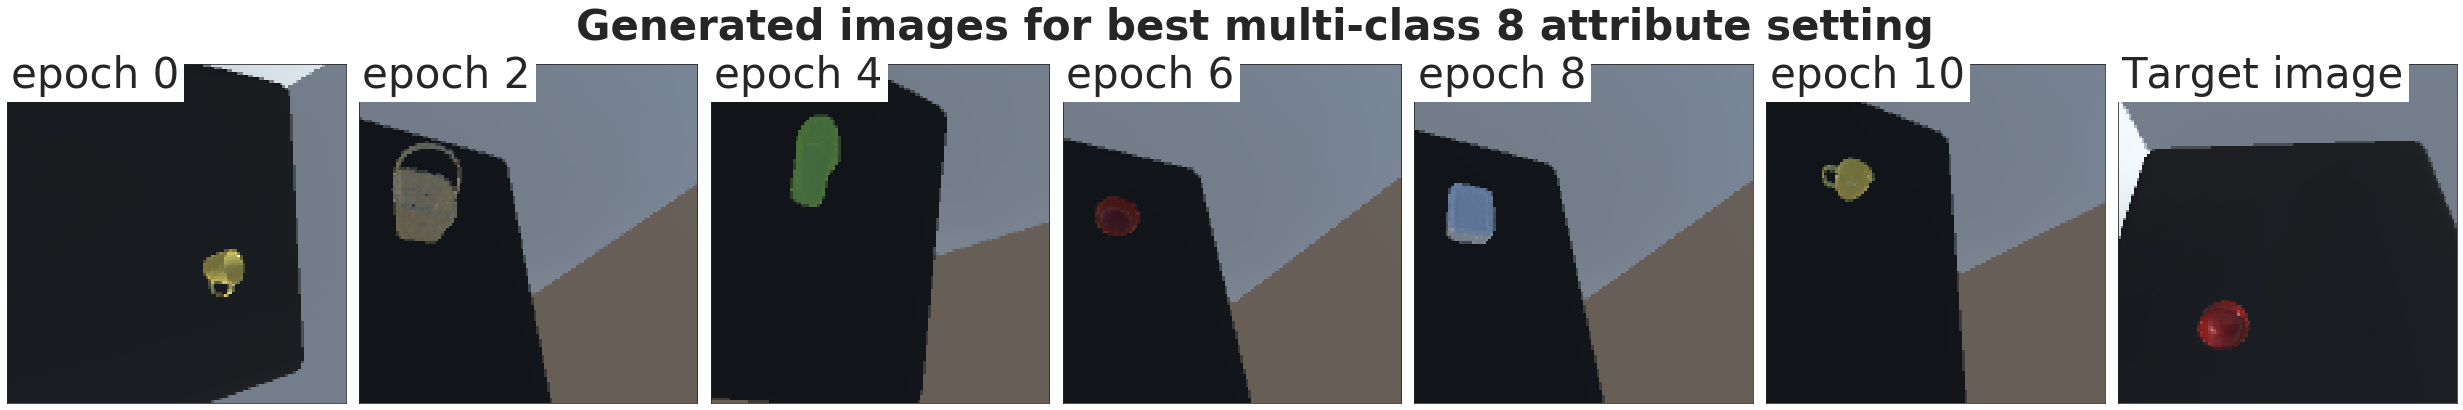

In [162]:
plot_each_image(
    experiment_n=1,
    interval=1,
    filename="multi_3attr_images",
    title="Generated images for best multi-class 8 attribute setting",
    total_epochs=10,
    fontsize=42,
)

/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/federicoarenasl/miniconda3/envs/metasim/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


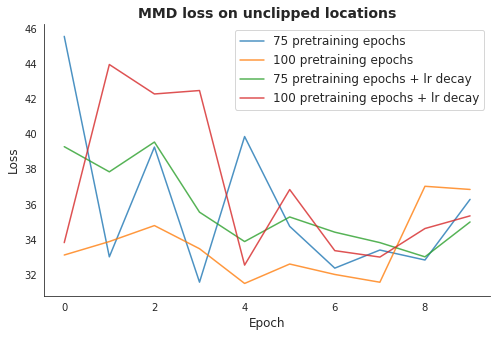

In [133]:
# Plot grid of distributions
labels = [
    "75 pretraining epochs",
    "100 pretraining epochs",
    "75 pretraining epochs + lr decay",
    "100 pretraining epochs + lr decay",
]
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 5))
exp_list = [1, 2, 3, 4]

for i, exp in enumerate(exp_list):
    plot_MMD_loss_joint(experiment_n=exp, label=labels[i], limit=10)

plt.title(f"MMD loss on unclipped locations", fontweight="bold", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
sns.despine(left=False, bottom=False)
plt.show()
fig.savefig(
    os.path.join(RESULTS_PATH, f"multi_8attr_MMD_loss.pdf"),
    bbox_inches="tight",
    pad_inches=0.1,
)